In [5]:
import numpy as np
import sympy
from sympy import *
from scipy.optimize import *
from matplotlib import pyplot as plt
%matplotlib inline

# Испытания решателей нелинейных уравнений

In [18]:
def f(x):
    a, b = x
    return [a + b - 3, a**2 + 2 * b**2 - 7]

def f_jac(x):
    a, b = x
    return np.array([[1, 1], [2 * a, 4 * b]])

In [19]:
%%timeit
nonlin_solve(f, [1, 2])

4.13 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%%timeit
nonlin_solve(f, [1, 2], jacobian=f_jac, )

1.71 ms ± 31.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
n = 10

init = [1] * n

def f(x):
    ff = [sum([k * x_ for x_ in x]) for k in range(len(x))]
    ff[0] = x[0] ** 2 + 2 * x[1] ** 2 - 4
    ff[1] = x[2] ** 2 + 3 * x[3] ** 3 - 10
    return ff
    
start_time = time()
res = newton_krylov(f, init)

print(f'Elapsed: {time() - start_time:.3}')
print(f'Max error: {max(np.abs(f(res)))}')

Elapsed: 0.271
Max error: 1.9516087057525056e-07


# Прямоугольник

<img src="https://content.screencast.com/users/Feldlime/folders/Jing/media/81360534-14e7-41ca-88a0-15044d2cca9b/2018-10-12_0925.png" align="left" width=300/>
<img src="https://content.screencast.com/users/Feldlime/folders/Jing/media/27d5f5d7-762a-4a0e-a87e-86dc9db25afc/2018-10-12_0929.png" align="left" width=300/>
<img src="https://content.screencast.com/users/Feldlime/folders/Jing/media/cf27c968-caec-4be4-b9b1-c63ccee1e1b3/2018-10-12_0940.png" width=300/>


**Делаем прямоугольник:**
1. Создаем 4 произвольных отрезка.
2. Связываем попарно их концы.
3. Закрепляем один из углов.
4. Делаем 3 из 4-х углов прямыми.
5. Закрепляем длины двух смежных сторон.

*Прямоугольник готов! (левая картинка)*
Он жесткий, его форму нельзя изменить, но он может вращаться вокруг закрепленного угла.

Теперь попробуем сделать прямым оставшийся угол (правая картинка).
Компас правильно понимает, что проблема именно в углах и подсвечивает их, остальные ограничения в порядке.
**Как он это понимает?**

Смотрим дальше.
Да, мы переопределили фигуру, но на самом деле ей ничто не мешает вращаться.
Но она не вращается. Видимо потому, что число степеней свободы формально сейчас 0.

Что интересно, если убрать закрепление точки (угла), то прямоугольник будет свободно двигаться, а подсветка ограничений останется прежней (что правильно).

## Система ограничений - вариант через координаты точек

In [114]:
def make_angle_between(x11, y11, x12, y12, x21, y21, x22, y22, angle):
    # Если важен направленный угол, то нужно сделать еще одно (или не одно?) уравнение
    
    a_x = x12 - x11
    a_y = y12 - y11
    b_x = x22 - x21
    b_y = y22 - y21
    
    prod = a_x * a_y + b_x * b_y
    len_a = sympy.sqrt(a_x ** 2 + a_y ** 2)
    len_b = sympy.sqrt(b_x ** 2 + b_y ** 2)
    
    cos = prod / (len_a * len_b)
    eq = Eq(cos, sympy.cos(angle))
    
    return eq

def make_length(x11, y11, x12, y12, length):
    dx = x12 - x11
    dy = y12 - y11
    len_ = sympy.sqrt(dx ** 2 + dy ** 2)
    eq = Eq(len_, length)
    return eq

In [115]:
# create ends of edges
points = {}
for n in range(1, 5):  # 4 edges
    for i in range(1, 3):  # 2 ends
        for coo in ['x', 'y']:
            name = f'{coo}{n}{i}'
            points[name] = symbols(name)
points

{'x11': x11,
 'y11': y11,
 'x12': x12,
 'y12': y12,
 'x21': x21,
 'y21': y21,
 'x22': x22,
 'y22': y22,
 'x31': x31,
 'y31': y31,
 'x32': x32,
 'y32': y32,
 'x41': x41,
 'y41': y41,
 'x42': x42,
 'y42': y42}

In [116]:
restrictions = {}

# combine points
for i in range(1, 5):
    for coo in 'xy':
        j = (i + 1) if i < 4 else 1
        restrictions[f'combine_{i}_{j}_{coo}'] = Eq(points[f'{coo}{i}2'], points[f'{coo}{j}1'])
        
# fix point in (0, 0)
for coo in 'xy':
    restrictions[f'fix_{coo}11'] = Eq(points[f'{coo}11'], 0)

# fix 3 right angles
for i, j in [(2, 3), (3, 4), (4, 1)]:
    points_ = [points[f'{coo}{k}{l}'] for k in [i, j] for l in [1, 2] for coo in 'xy']
    restrictions[f'right_angle_{i}_{j}'] = make_angle_between(*points_, sympy.pi / 2)
    
# fix 2 lengths (for 4mm)
for i in [1, 4]:
    points_ = [points[f'{coo}{i}{l}'] for l in [1, 2] for coo in 'xy']
    restrictions[f'length_{i}'] = make_length(*points_, 4)
    
restrictions

{'combine_1_2_x': Eq(x12, x21),
 'combine_1_2_y': Eq(y12, y21),
 'combine_2_3_x': Eq(x22, x31),
 'combine_2_3_y': Eq(y22, y31),
 'combine_3_4_x': Eq(x32, x41),
 'combine_3_4_y': Eq(y32, y41),
 'combine_4_1_x': Eq(x42, x11),
 'combine_4_1_y': Eq(y42, y11),
 'fix_x11': Eq(x11, 0),
 'fix_y11': Eq(y11, 0),
 'right_angle_2_3': Eq(((-x21 + x22)*(-y21 + y22) + (-x31 + x32)*(-y31 + y32))/(sqrt((-x21 + x22)**2 + (-y21 + y22)**2)*sqrt((-x31 + x32)**2 + (-y31 + y32)**2)), 0),
 'right_angle_3_4': Eq(((-x31 + x32)*(-y31 + y32) + (-x41 + x42)*(-y41 + y42))/(sqrt((-x31 + x32)**2 + (-y31 + y32)**2)*sqrt((-x41 + x42)**2 + (-y41 + y42)**2)), 0),
 'right_angle_4_1': Eq(((-x11 + x12)*(-y11 + y12) + (-x41 + x42)*(-y41 + y42))/(sqrt((-x11 + x12)**2 + (-y11 + y12)**2)*sqrt((-x41 + x42)**2 + (-y41 + y42)**2)), 0),
 'length_1': Eq(sqrt((-x11 + x12)**2 + (-y11 + y12)**2), 4),
 'length_4': Eq(sqrt((-x41 + x42)**2 + (-y41 + y42)**2), 4)}

### Попробуем решить систему уравнений из ограничений

In [117]:
system = [eq.lhs - eq.rhs for eq in restrictions.values()] 
symbols_ = list(points.values())

In [164]:
system.append(points['x12'] - 1)  # Чтобы была 16х16

In [25]:
%%time
# res = nonlinsolve(system, symbols_)

Wall time: 30.9 s


In [31]:
for i, solution in enumerate(res):
    print('Solution', i)
    for sym, r in zip(symbols_, solution):
        print(sym, r.evalf())

Solution 0
x11 0
y11 0
x12 1.00000000000000
y12 -3.87298334620742
x21 1.00000000000000
y21 -3.87298334620742
x22 2.00000000000000
y22 0
x31 2.00000000000000
y31 0
x32 1.00000000000000
y32 3.87298334620742
x41 1.00000000000000
y41 3.87298334620742
x42 0
y42 0
Solution 1
x11 0
y11 0
x12 1.00000000000000
y12 3.87298334620742
x21 1.00000000000000
y21 3.87298334620742
x22 2.00000000000000
y22 0
x31 2.00000000000000
y31 0
x32 1.00000000000000
y32 -3.87298334620742
x41 1.00000000000000
y41 -3.87298334620742
x42 0
y42 0
Solution 2
x11 0
y11 0
x12 1.00000000000000
y12 3.87298334620742
x21 1.00000000000000
y21 3.87298334620742
x22 0
y22 7.74596669241483
x31 0
y31 7.74596669241483
x32 -1.00000000000000
y32 3.87298334620742
x41 -1.00000000000000
y41 3.87298334620742
x42 0
y42 0
Solution 3
x11 0
y11 0
x12 1.00000000000000
y12 -3.87298334620742
x21 1.00000000000000
y21 -3.87298334620742
x22 0
y22 -7.74596669241483
x31 0
y31 -7.74596669241483
x32 -1.00000000000000
y32 -3.87298334620742
x41 -1.0000000

### Символьно решать медленно - пробуем численно

In [23]:
def system_to_function(system, symbols):
    functions = [lambdify(symbols, f) for f in system]
    
    def fun(x):
        if len(x) != len(symbols):
            raise ValueError
        res = np.array([f(*x) for f in functions])
        return res
    
    return fun


def get_jacobian(system, symbols):
    jac = []
    for i_expr, expr in enumerate(system):
        jac.append([0] * len(symbols))
        for i_sym, sym in enumerate(symbols):
            jac[i_expr][i_sym] = expr.diff(sym)
    return np.array(jac)


def jacobian_to_function(jac, symbols):
    functions = [[lambdify(symbols, der) for der in row] for row in jac]
    
    def fun(x):
        if len(x) != len(symbols):
            raise ValueError
        res = np.array([[f(*x) for f in row] for row in functions])
        return res
    
    return fun

In [187]:
%%time
fun = system_to_function(system, symbols_)

init = np.random.random(len(symbols_))

res = newton_krylov(fun, init, verbose=False)
print(res)

[ 5.37068698e-18  3.03367738e-18  1.00000000e+00  3.87298335e+00
  1.00000000e+00  3.87298335e+00  2.69612897e+00  1.58957451e+00
  2.69612897e+00  1.58957451e+00 -3.87298337e+00  9.99999981e-01
 -3.87298337e+00  9.99999981e-01  2.93829020e-18 -2.20934973e-18]
Wall time: 157 ms


In [188]:
res

array([ 5.37068698e-18,  3.03367738e-18,  1.00000000e+00,  3.87298335e+00,
        1.00000000e+00,  3.87298335e+00,  2.69612897e+00,  1.58957451e+00,
        2.69612897e+00,  1.58957451e+00, -3.87298337e+00,  9.99999981e-01,
       -3.87298337e+00,  9.99999981e-01,  2.93829020e-18, -2.20934973e-18])

In [151]:
%%time
res = broyden2(fun, init, verbose=False)

Wall time: 165 ms


In [174]:
%%time
fun = system_to_function(system, symbols_)

init = np.random.random(len(symbols_))

res = nonlin_solve(fun, init, verbose=False)
print(res)

ValueError: Jacobian inversion yielded zero vector. This indicates a bug in the Jacobian approximation.

In [119]:
%%time
fun = system_to_function(system, symbols_)
jac = jacobian_to_function(get_jacobian(system, symbols_), symbols_)

init = np.random.random(len(symbols_))

res = nonlin_solve(fun, init, jacobian=jac, verbose=False)
print(res)

[ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -3.87298335e+00
  1.00000000e+00 -3.87298335e+00 -3.87298335e+00 -1.41683664e+06
 -3.87298335e+00 -1.41683664e+06 -3.87298335e+00 -1.00000000e+00
 -3.87298335e+00 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
Wall time: 1.07 s


In [105]:
fun(res)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.53630600e-06, 1.86583234e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

### Строим граф ограничений

In [40]:
import networkx as nx
from itertools import combinations
from collections import defaultdict

In [74]:
g = nx.MultiGraph()
g.add_nodes_from(points)
g.add_node('growth')

In [75]:
for e in system:
    e_str = str(e)
    e_nodes = []
    for node in g.nodes:
        if node in e_str and node not in e_nodes:
            e_nodes.append(node)
    
    if len(e_nodes) == 0:
        raise RuntimeError
    elif len(e_nodes) == 1:
        g.add_edge(e_nodes[0], 'growth')
    else:
        for u, v in combinations(e_nodes, 2):
            g.add_edge(u, v)

In [76]:
# Count unique edges
unique_edges = defaultdict(int)
for edge in g.edges:
    unique_edges[(edge[0], edge[1])] += 1
unique_edges = dict(unique_edges)

In [77]:
unique_edges

{('x11', 'x42'): 2,
 ('x11', 'growth'): 1,
 ('x11', 'y11'): 2,
 ('x11', 'x12'): 2,
 ('x11', 'y12'): 2,
 ('x11', 'x41'): 1,
 ('x11', 'y41'): 1,
 ('x11', 'y42'): 1,
 ('y11', 'y42'): 2,
 ('y11', 'growth'): 1,
 ('y11', 'x12'): 2,
 ('y11', 'y12'): 2,
 ('y11', 'x41'): 1,
 ('y11', 'y41'): 1,
 ('y11', 'x42'): 1,
 ('x12', 'x21'): 1,
 ('x12', 'y12'): 2,
 ('x12', 'x41'): 1,
 ('x12', 'y41'): 1,
 ('x12', 'x42'): 1,
 ('x12', 'y42'): 1,
 ('x12', 'growth'): 1,
 ('y12', 'y21'): 1,
 ('y12', 'x41'): 1,
 ('y12', 'y41'): 1,
 ('y12', 'x42'): 1,
 ('y12', 'y42'): 1,
 ('x21', 'y21'): 1,
 ('x21', 'x22'): 1,
 ('x21', 'y22'): 1,
 ('x21', 'x31'): 1,
 ('x21', 'y31'): 1,
 ('x21', 'x32'): 1,
 ('x21', 'y32'): 1,
 ('y21', 'x22'): 1,
 ('y21', 'y22'): 1,
 ('y21', 'x31'): 1,
 ('y21', 'y31'): 1,
 ('y21', 'x32'): 1,
 ('y21', 'y32'): 1,
 ('x22', 'x31'): 2,
 ('x22', 'y22'): 1,
 ('x22', 'y31'): 1,
 ('x22', 'x32'): 1,
 ('x22', 'y32'): 1,
 ('y22', 'y31'): 2,
 ('y22', 'x31'): 1,
 ('y22', 'x32'): 1,
 ('y22', 'y32'): 1,
 ('x31', 'y

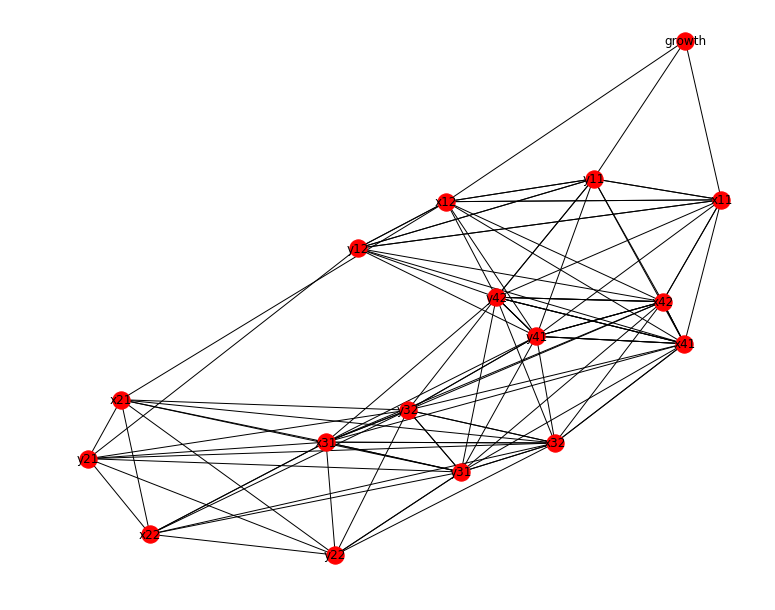

In [58]:
plt.figure(figsize=(10,8))
nx.draw(g, with_labels=True)

### Попытка решить задачу оптимизации

In [189]:
system_extended = system.copy()

In [190]:
system_extended.pop(-1)

x12 - 1

In [191]:
lambdas = symbols(' '.join(f'lambda_{i}' for i in range(len(system_extended))))

In [192]:
res = np.array([ 5.37068698e-18,  3.03367738e-18,  1.00000000e+00,  3.87298335e+00,
        1.00000000e+00,  3.87298335e+00,  2.69612897e+00,  1.58957451e+00,
        2.69612897e+00,  1.58957451e+00, -3.87298337e+00,  9.99999981e-01,
       -3.87298337e+00,  9.99999981e-01,  2.93829020e-18, -2.20934973e-18])

In [193]:
F = 1/2 * sum([(sym - res[i]) ** 2 for i, sym in enumerate(symbols_)])

In [196]:
F += sum([lambdas[i] * expr for i, expr in enumerate(system_extended)])

In [198]:
for sym in symbols_:
    system_extended.append(F.diff(sym))

In [202]:
symbols_extended = symbols_ + list(lambdas)

In [224]:
%%time
fun = system_to_function(system_extended, symbols_extended)

Wall time: 376 ms


In [235]:
%%time
init = np.random.random(len(symbols_extended))

res = broyden2(fun, init, verbose=False)
print(res)

[-4.57741764e-08  5.48291266e-08  9.99996442e-01  3.87298408e+00
  9.99996504e-01  3.87298418e+00  2.69613309e+00  1.58956831e+00
  2.69613311e+00  1.58956850e+00 -3.87298457e+00  9.99994940e-01
 -3.87298433e+00  9.99994758e-01 -2.83898461e-07  1.32673474e-07
  5.73082135e-06 -6.25912121e-06  5.24480194e-06 -9.28565364e-07
  2.29405830e-06  1.00540292e-05  3.44926111e-06  1.50529504e-05
  1.10533798e-06  2.09334657e-05  8.34332680e-05 -8.76234338e-05
 -1.44285529e-05  6.44591482e-06 -8.08974329e-06]
Wall time: 761 ms


## Система ограничений - вариант через начало, длину, угол

In [7]:
# create values
points_2 = {}
for n in range(1, 5):  # 4 edges
    for coo in ['x', 'y']:
        name = f'{coo}_{n}'
        points_2[name] = symbols(name)
    points_2[f'length_{n}'] = symbols(f'length_{n}')
    points_2[f'angle_{n}'] = symbols(f'angle_{n}')
points_2

{'x_1': x_1,
 'y_1': y_1,
 'length_1': length_1,
 'angle_1': angle_1,
 'x_2': x_2,
 'y_2': y_2,
 'length_2': length_2,
 'angle_2': angle_2,
 'x_3': x_3,
 'y_3': y_3,
 'length_3': length_3,
 'angle_3': angle_3,
 'x_4': x_4,
 'y_4': y_4,
 'length_4': length_4,
 'angle_4': angle_4}

In [18]:
restrictions_2 = {}

# combine points
for i in range(1, 5):
    for coo in 'xy':
        j = (i + 1) if i < 4 else 1
        fun = sympy.cos if coo == 'x' else sympy.sin
        end = points_2[f'{coo}_{i}'] + points_2[f'length_{i}'] * fun(points_2[f'angle_{i}'])
        restrictions_2[f'combine_{i}_{j}_{coo}'] = Eq(points_2[f'{coo}_{j}'], end)
        
# fix point in (0, 0)
for coo in 'xy':
    restrictions_2[f'fix_{coo}_1'] = Eq(points_2[f'{coo}_1'], 0)

# fix 3 right angles
for i, j in [(2, 3), (3, 4), (4, 1)]:
    restrictions_2[f'right_angle_{i}_{j}'] = Eq((points_2[f'angle_{i}'] - points_2[f'angle_{j}']) % sympy.pi, sympy.pi / 2)
    
# fix 2 lengths (for 4mm)
for i in [1, 4]:
    restrictions_2[f'fix_length_{i}'] = Eq(points_2[f'length_{i}'], 4)
    
restrictions_2

{'combine_1_2_x': Eq(x_2, length_1*cos(angle_1) + x_1),
 'combine_1_2_y': Eq(y_2, length_1*sin(angle_1) + y_1),
 'combine_2_3_x': Eq(x_3, length_2*cos(angle_2) + x_2),
 'combine_2_3_y': Eq(y_3, length_2*sin(angle_2) + y_2),
 'combine_3_4_x': Eq(x_4, length_3*cos(angle_3) + x_3),
 'combine_3_4_y': Eq(y_4, length_3*sin(angle_3) + y_3),
 'combine_4_1_x': Eq(x_1, length_4*cos(angle_4) + x_4),
 'combine_4_1_y': Eq(y_1, length_4*sin(angle_4) + y_4),
 'fix_x_1': Eq(x_1, 0),
 'fix_y_1': Eq(y_1, 0),
 'right_angle_2_3': Eq(Mod(angle_2 - angle_3, pi), pi/2),
 'right_angle_3_4': Eq(Mod(angle_3 - angle_4, pi), pi/2),
 'right_angle_4_1': Eq(Mod(-angle_1 + angle_4, pi), pi/2),
 'fix_length_1': Eq(length_1, 4),
 'fix_length_4': Eq(length_4, 4)}

In [19]:
system_2 = [eq.lhs - eq.rhs for eq in restrictions_2.values()] 
symbols_2 = list(points_2.values())

In [20]:
%%time
res = nonlinsolve(system_2, symbols_2)

KeyboardInterrupt: 

In [21]:
system_2.append(points_2['x_2'] - 1)  # Чтобы была 16х16

In [52]:
%%time
fun = system_to_function(system_2, symbols_2)

init = np.random.random(len(symbols_2))

res = broyden2(fun, init, verbose=False)
print(res)

[ 4.97114229e-07 -5.01851902e-08  4.00000018e+00 -1.31811619e+00
  9.99999324e-01 -3.87298428e+00 -4.00000099e+00  2.52679999e-01
 -2.87298465e+00 -4.87298680e+00  3.99999977e+00  1.82347666e+00
 -3.87298493e+00 -9.99998677e-01  3.99999996e+00  2.52680091e-01]
Wall time: 205 ms


In [107]:
%%time
res = broyden(fun, init, verbose=False)
print(res)

NoConvergence: [ 3.91358563e-01  1.47975959e-02  3.94617409e+00  7.15696457e+03
  7.41072084e-01 -5.26466145e+00  4.60540590e+03  3.09769971e+02
 -5.18909878e+03  3.30769088e+03  8.38864539e+03  2.05451529e+02
  6.74070325e+00  6.63695327e+00  3.98361169e+00 -4.47775725e+03]

In [40]:
%%time
fun = system_to_function(system_2, symbols_2)

init = np.random.random(len(symbols_2))

res = nonlin_solve(fun, init, verbose=False)
print(res)

[ 1.98754817e-18 -3.33070274e-19  4.00000000e+00  1.31811607e+00
  1.00000000e+00  3.87298335e+00 -4.00000000e+00 -2.52680255e-01
 -2.87298335e+00  4.87298335e+00 -4.00000000e+00  1.31811607e+00
 -3.87298335e+00  1.00000000e+00  4.00000000e+00 -2.52680255e-01]
Wall time: 398 ms


In [120]:
%%time
fun = system_to_function(system_2, symbols_2)
jac = jacobian_to_function(get_jacobian(system_2, symbols_2), symbols_2)

init = np.random.random(len(symbols_2))

res = nonlin_solve(fun, init, jacobian=jac, verbose=False)
print(res)

NameError: name 'Subs' is not defined